In [ ]:
# !pip install torchtext==0.6
# !python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 1.2 MB 10.5 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.0
    Uninstalling torchtext-0.13.0:
      Successfully uninstalled torchtext-0.13.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import os
import random
import spacy
import torch 
import pandas as pd
from torchtext import data
import torch.optim as optim
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

SEED = 0
torch.manual_seed(SEED)
torch.backends.cuda.deterministic = True

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/'
best_model_path = os.path.join(root_dir,'model.pt')
metrics_path = os.path.join(root_dir,'metrics.pt')

file_path = os.path.join(root_dir,'sms_spam.csv')

df = pd.read_csv(file_path)
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Data Preprocessing
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

TEXT = data.Field(tokenize=tokenizer, batch_first=True, lower=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)

fields = [("label", LABEL),('text', TEXT)]

# # Tabular Dataset
# train, valid, test = data.TabularDataset.splits(path=destination_folder, train='train.csv', validation='valid.csv', test='test.csv',
#                                            format='CSV', fields=fields, skip_header=True)


spam_data = data.TabularDataset(path='/content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/sms_spam.csv'\
                              ,format='csv'\
                              ,fields=fields\
                              ,skip_header=True)

print(vars(spam_data.examples[0]))

{'label': 'ham', 'text': ['go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amore', 'wat', '...']}


In [ ]:
# train and validation splitting
train, valid = spam_data.split(split_ratio=0.75, random_state=random.seed(SEED))
print('number of train : {}'.format(len(train)))
print('number of valid : {}'.format(len(valid)))

number of train : 4180
number of valid : 1394


In [ ]:
# Building vocabularies => (Token to integer)
TEXT.build_vocab(train, min_freq=5)
LABEL.build_vocab(train)

print("Size of text vocab:",len(TEXT.vocab))
print("Size of label vocab:",len(LABEL.vocab))

Size of text vocab: 1559
Size of label vocab: 2


In [ ]:
# print most common vocab top5
TEXT.vocab.freqs.most_common(5)

[('.', 3735), ('i', 2217), ('to', 1692), ('you', 1678), (',', 1445)]

In [ ]:
# Creating GPU variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train, valid),
    batch_size=batch_size,
    sort_key=lambda x:len(x.text),
    sort=True,
    sort_within_batch=True,
    device=device
)

# test_iterator = data.BucketIterator(
#     test,
#     batch_size=batch_size,
#     sort_key=lambda x:len(x.text),
#     sort=True,
#     sort_within_batch=True,
#     device=device
# )

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence
# LSTM Network Model
import torch.nn as nn

class LSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        
        super(LSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer process the vector sequences
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout,
                            batch_first=True)
        
        # Dense layer to predict
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        # Prediction activation function
        self.sigmoid = nn.Sigmoid()  #nn.Softmax()

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)

        # pack_padded_sequence : padding된 문장을 padding 기준으로 sorting 하는 역할
        # 참고할 글 : https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        
        # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        dense_outputs=self.fc(hidden)
        outputs = self.sigmoid(dense_outputs)

        return outputs

In [ ]:
# Hyper-parameters
SIZE_OF_VOCAB = len(TEXT.vocab)
EMBEDDING_DIM = 100
NUM_HIDDEN_NODES = 64
NUM_OUTPUT_NODES = 1
NUM_LAYERS = 2
BIDIRECTION = True
DROPOUT = 0.2

#Training

LSTM_Model = LSTM(SIZE_OF_VOCAB,
                EMBEDDING_DIM,
                NUM_HIDDEN_NODES,
                NUM_OUTPUT_NODES,
                NUM_LAYERS,
                BIDIRECTION,
                DROPOUT
               )

model = LSTM_Model.to(device) # cudnn관련 에러났을 때, 다시 코드 돌리면 정상적으로 작동됩니다!!
print(model)

optimizer = optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.BCELoss() # if # of class > 2, nn.CrossEntropyLoss()
criterion = criterion.to(device)

LSTM(
  (embedding): Embedding(1559, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    
    print(f'Model saved to ==> {save_path}')
    print()


def load_metrics(load_path):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
def train(model, optimizer, criterion, train_loader, valid_loader, num_epochs, folder_path):
    train_running_loss = 0.0; train_running_acc = 0.0
    valid_running_loss = 0.0; valid_running_acc = 0.0
    global_step = 0; eval_every = len(train_loader)//2; best_valid_loss = float("Inf")
    train_loss = list(); valid_loss = list(); global_steps = list()

    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            text, text_lengths = batch.text
            pred = model(text, text_lengths).squeeze()

            optimizer.zero_grad()
            loss = criterion(pred, batch.label)
            loss.backward()

            acc = binary_accuracy(pred,batch.label)

            optimizer.step()

            train_running_loss += loss.item()
            train_running_acc += acc.item()
            global_step += 1
            
            

            if global_step % eval_every == 0 :
                model.eval()
                with torch.no_grad():
                    for batch in valid_loader:
                        text, text_lengths = batch.text
                        pred = model(text, text_lengths).squeeze()

                        loss = criterion(pred, batch.label)
                        acc = binary_accuracy(pred, batch.label)
                        
                        valid_running_loss += loss.item()
                        valid_running_acc += acc.item()
                


                # evaluation
                average_train_loss = train_running_loss / eval_every
                average_train_acc = train_running_acc / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                average_valid_acc = valid_running_acc / len(valid_loader)
                train_loss.append(average_train_loss)
                valid_loss.append(average_valid_loss)
                global_steps.append(global_step)

                # resetting running values
                train_running_loss = 0.0; train_running_acc = 0.0
                valid_running_loss = 0.0; valid_running_acc = 0.0

                model.train()

                # print progress
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{global_step}/{num_epochs*len(train_loader)}], Train Loss: {average_train_loss:.3f}, Train Acc: {average_train_acc*100:.2f}% | Valid Loss: {average_valid_loss:.3f}, Val Acc: {average_valid_acc*100:.2f}%')
                print()


                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(best_model_path, model, optimizer, best_valid_loss) #torch.save(model.state_dict(), best_model_path)
                    save_metrics(metrics_path, train_loss, valid_loss, global_steps)

    save_metrics(metrics_path, train_loss, valid_loss, global_steps)
    print('Finished Training!')

In [ ]:
# Model Training

train(model=model, 
      optimizer=optimizer, 
      criterion=criterion, 
      train_loader=train_iterator, 
      valid_loader=valid_iterator, 
      num_epochs=15, 
      folder_path=root_dir)

Epoch [1/15], Step [33/990], Train Loss: 0.649, Train Acc: 95.27%) | Valid Loss: 0.629, Val Acc: 86.21%

Model saved to ==> /content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/metrics.pt

Epoch [1/15], Step [66/990], Train Loss: 0.634, Train Acc: 75.28%) | Valid Loss: 0.581, Val Acc: 86.21%

Model saved to ==> /content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/metrics.pt

Epoch [2/15], Step [99/990], Train Loss: 0.482, Train Acc: 98.48%) | Valid Loss: 0.480, Val Acc: 86.21%

Model saved to ==> /content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/metrics.pt

Epoch [2/15], Step [132/990], Train Loss: 0.560, Train Acc: 75.28%) | Valid Loss: 0.439, Val Acc: 86.21%

Model saved to ==>

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/metrics.pt


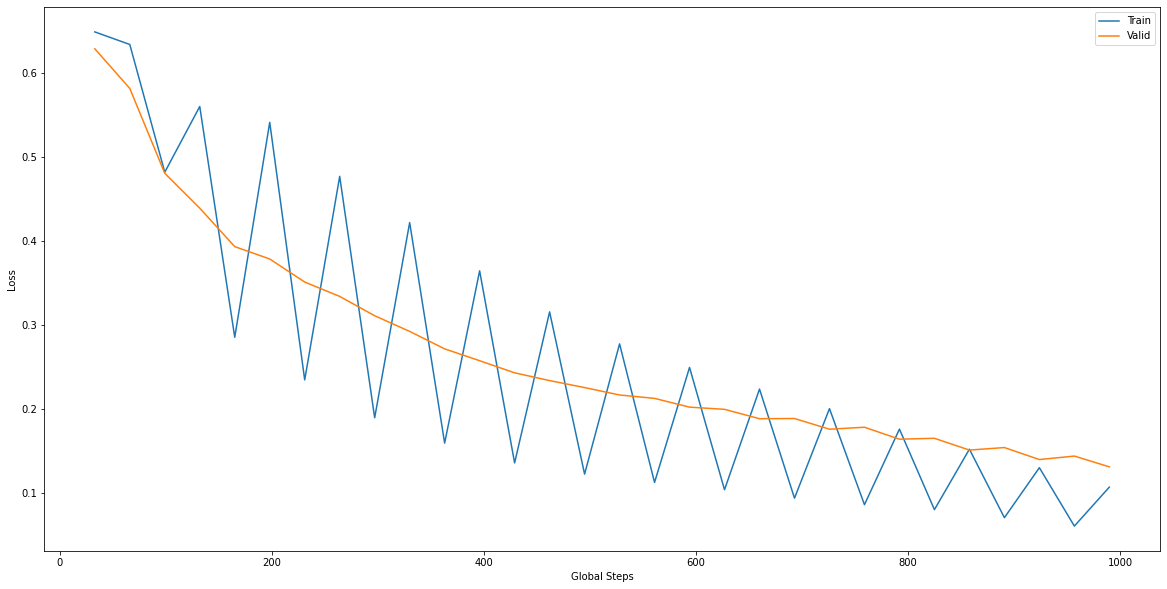

In [ ]:
# Evaluation
train_loss_list, valid_loss_list, global_steps_list = load_metrics(os.path.join(root_dir,'metrics.pt'))
plt.figure(figsize=(20,10))
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8359    0.8446    0.8402       193
           0     0.9750    0.9734    0.9742      1201

    accuracy                         0.9555      1394
   macro avg     0.9054    0.9090    0.9072      1394
weighted avg     0.9557    0.9555    0.9556      1394



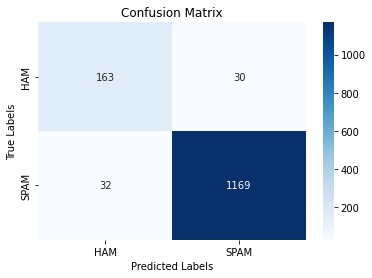

In [ ]:
# Evaluation Function
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            text, text_lengths = batch.text
            pred = model(text, text_lengths).squeeze()
            output = (pred > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(batch.label.tolist())

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['HAM', 'SPAM'])  # Label명 변경바람!!
    ax.yaxis.set_ticklabels(['HAM', 'SPAM'])  # Label명 변경바람!!

# best_model = LSTM().to(device)
# optimizer = optim.Adam(best_model.parameters(), lr=0.001)


# test = data.TabularDataset(path='???'\
#                               ,format='csv'\
#                               ,fields=fields\
#                               ,skip_header=True)

# test_iterator = data.BucketIterator(
#     test,
#     batch_size=batch_size,
#     sort_key=lambda x:len(x.text),
#     sort=True,
#     sort_within_batch=True,
#     device=device
# )

load_checkpoint(best_model_path, model, optimizer)
evaluate(model, valid_iterator) # valid_iter - > test_iter 변경바람!!

In [ ]:
# 향후, 실제 테스트 관련 코드!!
load_checkpoint(best_model_path, model, optimizer)
model.eval();

#inference 

idx_to_label = {1: "HAM",
                2: "SPAM"}


def predict(model, sentence):
    tokenized = tokenizer(sentence)
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]      
    length = [len(indexed)]                                
    tensor = torch.LongTensor(indexed).to(device)            
    tensor = tensor.unsqueeze(1).T                         
    length_tensor = torch.LongTensor(length)                  
    prediction = model(tensor, length_tensor)                  
    return prediction.argmax(1).item() + 1               


#make predictions
class_num = predict(model, "Nah I don't think he goes to usf, he lives around here though")
print(f"* This is a {idx_to_label[class_num]} *")


Model loaded from <== /content/drive/MyDrive/Colab Notebooks/LSTM-Text-Classification/model.pt
* This is a HAM *


In [ ]:
df.loc[4]

type                                                  ham
text    Nah I don't think he goes to usf, he lives aro...
Name: 4, dtype: object